In [1]:
!pip install roboflow

from roboflow import Roboflow
import os
import pandas as pd
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing import image as imageTf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from keras import Sequential, layers
from keras.regularizers import l2
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
rf = Roboflow(api_key="KKqIUCZqtzPxGxj9yDjD")
project = rf.workspace("crop-recomendation-wfyn7").project("soil-type-ladmq")
version = project.version(6)
dataset = version.download("multiclass")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Soil-Type-6 in multiclass:: 100%|██████████| 11658/11658 [00:01<00:00, 6326.08it/s]


In [3]:
download_dataset_dir = os.path.join(os.getcwd(), "Soil-Type-6")
folder_name = 'dataset'

In [4]:
if not os.path.exists(folder_name):
    # Buat folder
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' berhasil dibuat.")
else:
    print(f"Folder '{folder_name}' sudah ada.")

Folder 'dataset' berhasil dibuat.


In [5]:
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    os.makedirs(folder_name+'/train')
    os.makedirs(folder_name+'/test')
    os.makedirs(folder_name+'/val')

In [6]:
download_dataset_dirs = ['test', 'train', 'valid']
dataset_destination_dirs = ['test', 'train', 'val']

for idx, (dir) in enumerate(download_dataset_dirs):
  df = pd.read_csv(os.path.join(download_dataset_dir, dir, '_classes.csv'), header=None)
  header = df.iloc[0]
  classes = header[1:]

  data = df.iloc[1:]

  for index, row in data.iterrows():
    filename = row[0]

    class_index: int = -1
    for index in range(1, len(classes) + 1):
      if int(row[index]) == 1:
        class_index = index - 1
        break

    if (class_index == -1):
      continue

    class_name = classes.iloc[class_index]
    if not os.path.exists(os.path.join('dataset', dataset_destination_dirs[idx], class_name)):
      os.makedirs(os.path.join('dataset', dataset_destination_dirs[idx], class_name))

    try:
      shutil.copy(
          os.path.join(download_dataset_dir, dir, filename),
          os.path.join('dataset', dataset_destination_dirs[idx], class_name, filename))
    except:
      print(f'File {filename} not found')

In [7]:
train_dir = folder_name+'/train'
val_dir = folder_name+'/val'
test_dir = folder_name+'/test'

# image_size = 224
# batch_size = 32
# epoch = 15

In [9]:
# Transformasi data
transform_train = transforms.Compose([
    transforms.Resize((224, 224)), # Augmentasi
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset
train_dataset = ImageFolder(root=train_dir, transform=transform_train)
val_dataset = ImageFolder(root=val_dir, transform=transform_val_test)
test_dataset = ImageFolder(root=test_dir, transform=transform_val_test)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
# # Load pre-trained ResNet101
# model = models.resnet101(pretrained=True)

# # Replace all ReLU activations with LeakyReLU
# for name, module in list(model.named_modules()):  # Use list to create a copy of named_modules
#     if isinstance(module, nn.ReLU):  # Check for ReLU layers
#         # Replace ReLU with LeakyReLU
#         parent_name = name.rsplit('.', 1)[0] if '.' in name else ''
#         parent = dict(model.named_modules()).get(parent_name, model)  # Get parent module
#         setattr(parent, name.split('.')[-1], nn.LeakyReLU(inplace=True))

#print(model)  # Display modified model

class CustomResNet101(nn.Module):
    def __init__(self, num_classes=11, dropout_prob=0.5):
        super(CustomResNet101, self).__init__()
        # Load pretrained ResNet101
        self.base_model = models.resnet101(pretrained=True)

        # Replace the original fully connected layer with a custom sequential layer
        self.base_model.fc = nn.Sequential(
            nn.Dropout(p=dropout_prob),  # Dropout layer for regularization
            nn.Linear(in_features=2048, out_features=num_classes)  # Fully connected layer
        )

    def forward(self, x):
        return self.base_model(x)

# Create an instance of the model
model = CustomResNet101(num_classes=11, dropout_prob=0.5)

# Print the model to verify the structure
print(model)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 169MB/s]


CustomResNet101(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [11]:
# Modify layer4 with fewer neurons (filters)
new_layer4 = nn.Sequential(
    nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, bias=False),  # Reduce filters to 1024
    nn.BatchNorm2d(1024),
    nn.ReLU(inplace=True),
    nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, bias=False),  # Output remains 1024
    nn.BatchNorm2d(1024),
    nn.ReLU(inplace=True)
)
model.layer4 = new_layer4

print(model.layer4)

Sequential(
  (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
)


In [12]:
#print(model)

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [14]:
def train_model_with_test(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience)

    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / total)
        train_accuracies.append(correct / total)

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / total)
        val_accuracies.append(correct / total)

        # Test Phase
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_losses.append(test_loss / total)
        test_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")
        print(f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")

        # Update learning rate using scheduler
        scheduler.step()
        print(f"Current learning rate: {scheduler.get_last_lr()}")

        # Check for early stopping
        early_stopping(val_losses[-1])
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  # Loss untuk klasifikasi multi-kelas
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = train_model_with_test(
    model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50, patience=7
)


Epoch 1/50
Train Loss: 0.5067, Train Acc: 0.8448
Val Loss: 0.1344, Val Acc: 0.9589
Test Loss: 0.1175, Test Acc: 0.9633
Current learning rate: [0.001]
Epoch 2/50
Train Loss: 0.1393, Train Acc: 0.9579
Val Loss: 0.0894, Val Acc: 0.9719
Test Loss: 0.0909, Test Acc: 0.9721
Current learning rate: [0.001]
Epoch 3/50
Train Loss: 0.0691, Train Acc: 0.9799
Val Loss: 0.0885, Val Acc: 0.9726
Test Loss: 0.0843, Test Acc: 0.9795
Current learning rate: [0.001]
Epoch 4/50
Train Loss: 0.0465, Train Acc: 0.9865
Val Loss: 0.0880, Val Acc: 0.9726
Test Loss: 0.0744, Test Acc: 0.9824
Current learning rate: [0.001]
Epoch 5/50
Train Loss: 0.0345, Train Acc: 0.9898
Val Loss: 0.0907, Val Acc: 0.9798
Test Loss: 0.1009, Test Acc: 0.9736
Current learning rate: [0.001]
Epoch 6/50
Train Loss: 0.0226, Train Acc: 0.9937
Val Loss: 0.0877, Val Acc: 0.9805
Test Loss: 0.0852, Test Acc: 0.9809
Current learning rate: [0.001]
Epoch 7/50
Train Loss: 0.0139, Train Acc: 0.9974
Val Loss: 0.0841, Val Acc: 0.9812
Test Loss: 0.1026

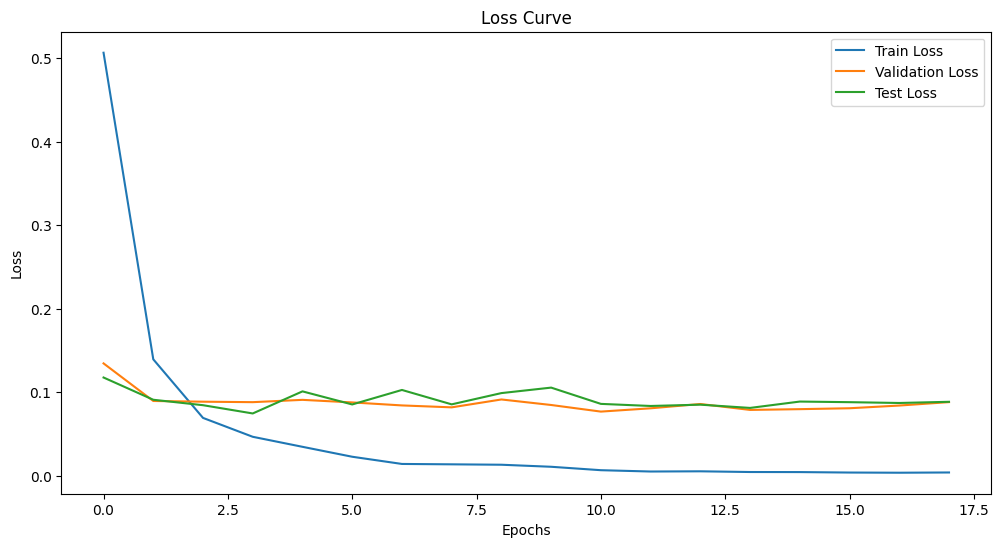

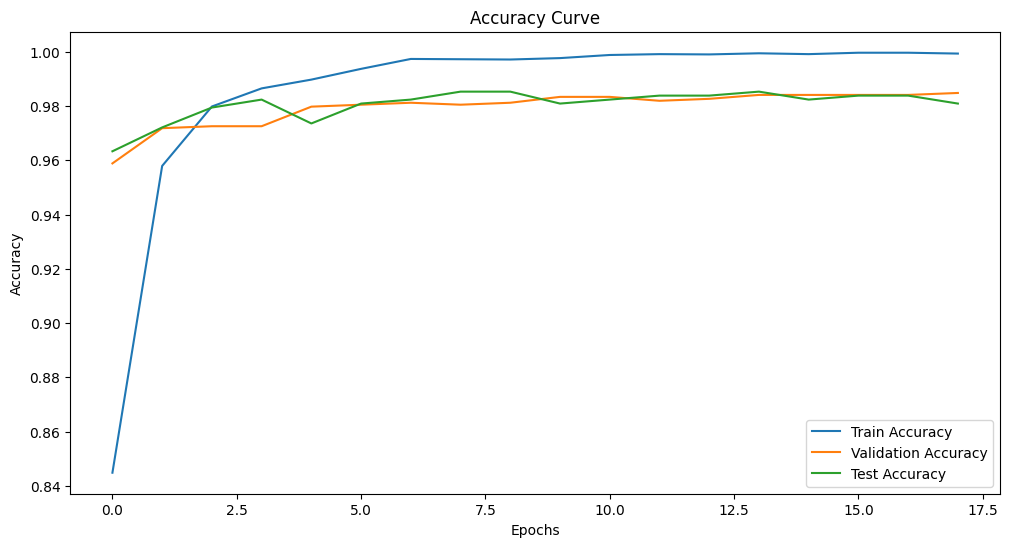

In [16]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()


In [17]:
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

test_model(model, test_loader)


Test Accuracy: 98.09%


Saving andosol-005.jpg to andosol-005.jpg
Predicted class index: 10
Predicted class label:  yellow


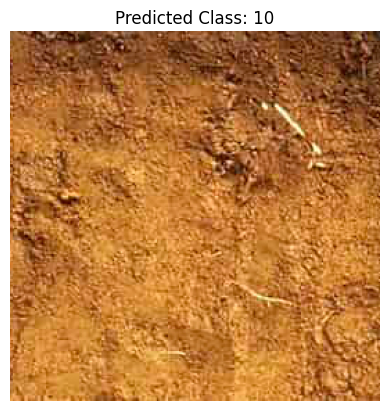

In [18]:

from PIL import Image
from google.colab import files

# Upload file
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    break

# Load the image
image = Image.open(img_path).convert("RGB")

# Apply the same transformations as during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Pastikan ukuran sesuai dengan model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transform the image
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Perform prediction
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(input_tensor)

# Get predicted class
_, predicted_class = torch.max(outputs, 1)

class_names = train_dataset.classes

# Display the result
print(f"Predicted class index: {predicted_class.item()}")
print(f"Predicted class label: {class_names[predicted_class.item()]}")

# Plot the image
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class.item()}")
plt.axis("off")
plt.show()
